## ThinkDSP

This notebook contains code examples from Chapter 6: Discrete Cosine Transform

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [2]:
import numpy as np
PI2 = np.pi * 2

### Synthesis

The simplest way to synthesize a mixture of sinusoids is to add up sinusoid signals and evaluate the sum.

In [3]:
from thinkdsp import CosSignal, SumSignal

def synthesize1(amps, fs, ts):
    components = [CosSignal(freq, amp)
                  for amp, freq in zip(amps, fs)]
    signal = SumSignal(*components)

    ys = signal.evaluate(ts)
    return ys

Here's an example that's a mixture of 4 components.

In [4]:
from thinkdsp import Wave

amps = np.array([0.6, 0.25, 0.1, 0.05])
fs = [100, 200, 300, 400]
framerate = 11025

ts = np.linspace(0, 1, framerate, endpoint=False)
ys = synthesize1(amps, fs, ts)
wave = Wave(ys, ts, framerate)
wave.apodize()
wave.make_audio()

We can express the same process using matrix multiplication.

In [5]:
def synthesize2(amps, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    ys = np.dot(M, amps)
    return ys

And it should sound the same.

In [6]:
ys = synthesize2(amps, fs, ts)
wave = Wave(ys, framerate)
wave.apodize()
wave.make_audio()

And we can confirm that the differences are small.

In [7]:
ys1 = synthesize1(amps, fs, ts)
ys2 = synthesize2(amps, fs, ts)
np.max(np.abs(ys1 - ys2))

1.279532035880493e-13

### Analysis

The simplest way to analyze a signal---that is, find the amplitude for each component---is to create the same matrix we used for synthesis and then solve the system of linear equations.

In [8]:
def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

Using the first 4 values from the wave array, we can recover the amplitudes.

In [9]:
n = len(fs)
amps2 = analyze1(ys[:n], fs, ts[:n])
amps2

array([0.6 , 0.25, 0.1 , 0.05])

What we have so far is a simple version of a discrete cosine tranform (DCT), but it is not an efficient implementation because the matrix we get is not orthogonal.

In [10]:
# suppress scientific notation for small numbers
np.set_printoptions(precision=3, suppress=True)

In [11]:
def test1():
    N = 4.0
    time_unit = 0.001
    ts = np.arange(N) / N * time_unit
    max_freq = N / time_unit / 2
    fs = np.arange(N) / N * max_freq
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    return M

M = test1()
M

array([[ 1.   ,  1.   ,  1.   ,  1.   ],
       [ 1.   ,  0.707,  0.   , -0.707],
       [ 1.   ,  0.   , -1.   , -0.   ],
       [ 1.   , -0.707, -0.   ,  0.707]])

To check whether a matrix is orthogonal, we can compute $M^T M$, which should be the identity matrix:

In [12]:
M.transpose().dot(M)

array([[ 4.,  1., -0.,  1.],
       [ 1.,  2.,  1., -0.],
       [-0.,  1.,  2.,  1.],
       [ 1., -0.,  1.,  2.]])

But it's not, which means that this choice of M is not orthogonal.

Solving a linear system with a general matrix (that is, one that does not have nice properties like orthogonality) takes time proportional to $N^3$.  With an orthogonal matrix, we can get that down to $N^2$.  Here's how:

In [13]:
def test2():
    N = 4.0
    ts = (0.5 + np.arange(N)) / N
    fs = (0.5 + np.arange(N)) / 2
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    return M
    
M = test2()
M

array([[ 0.981,  0.831,  0.556,  0.195],
       [ 0.831, -0.195, -0.981, -0.556],
       [ 0.556, -0.981,  0.195,  0.831],
       [ 0.195, -0.556,  0.831, -0.981]])

Now $M^T M$ is $2I$ (approximately), so M is orthogonal except for a factor of two.

In [14]:
M.transpose().dot(M)

array([[ 2.,  0.,  0.,  0.],
       [ 0.,  2., -0., -0.],
       [ 0., -0.,  2., -0.],
       [ 0., -0., -0.,  2.]])

And that means we can solve the analysis problem using matrix multiplication.

In [15]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = M.dot(ys) / 2
    return amps

It works:

In [16]:
n = len(fs)
amps2 = analyze1(ys[:n], fs, ts[:n])
amps2

array([0.6 , 0.25, 0.1 , 0.05])

### DCT

What we've implemented is DCT-IV, which is one of several versions of DCT using orthogonal matrices.

In [17]:
def dct_iv(ys):
    N = len(ys)
    ts = (0.5 + np.arange(N)) / N
    fs = (0.5 + np.arange(N)) / 2
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

We can check that it works:

In [18]:
amps = np.array([0.6, 0.25, 0.1, 0.05])
N = 4.0
ts = (0.5 + np.arange(N)) / N
fs = (0.5 + np.arange(N)) / 2
ys = synthesize2(amps, fs, ts)

amps2 = dct_iv(ys)
np.max(np.abs(amps - amps2))

5.551115123125783e-17

DCT and inverse DCT are the same thing except for a factor of 2.

In [19]:
def inverse_dct_iv(amps):
    return dct_iv(amps) * 2

And it works:

In [20]:
amps = [0.6, 0.25, 0.1, 0.05]
ys = inverse_dct_iv(amps)
amps2 = dct_iv(ys)
np.max(np.abs(amps - amps2))

5.551115123125783e-17

###  Dct

`thinkdsp` provides a `Dct` class that encapsulates the DCT in the same way the Spectrum class encapsulates the FFT.

In [21]:
from thinkdsp import TriangleSignal

signal = TriangleSignal(freq=400)
wave = signal.make_wave(duration=1.0, framerate=10000)
wave.make_audio()

To make a Dct object, you can invoke `make_dct` on a Wave.

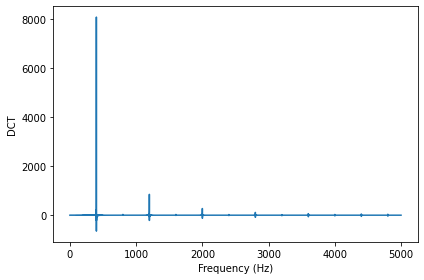

In [22]:
from thinkdsp import decorate

dct = wave.make_dct()
dct.plot()
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

Dct provides `make_wave`, which performs the inverse DCT.

In [23]:
wave2 = dct.make_wave()

The result is very close to the wave we started with.

In [24]:
np.max(np.abs(wave.ys-wave2.ys))

7.771561172376096e-16

Negating the signal changes the sign of the DCT.

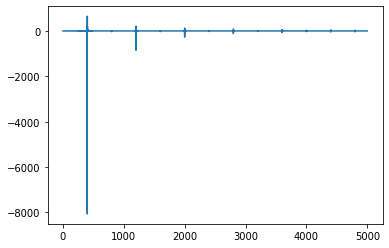

In [25]:
signal = TriangleSignal(freq=400, offset=0)
wave = signal.make_wave(duration=1.0, framerate=10000)
wave.ys *= -1
wave.make_dct().plot()

Adding phase offset $\phi=\pi$ has the same effect.

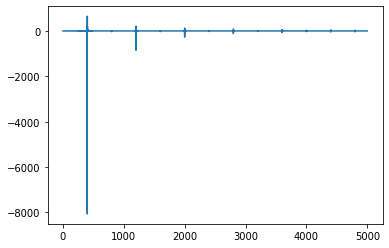

In [26]:
signal = TriangleSignal(freq=400, offset=np.pi)
wave = signal.make_wave(duration=1.0, framerate=10000)
wave.make_dct().plot()